<a href="https://colab.research.google.com/github/LinggarM/Jovian-Cat-Classifier/blob/master/Jovian_Classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [32]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [33]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8171650665019349936, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7250706432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1119010490350187231
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
train_files = glob.glob('/content/drive/My Drive/Upload/Machine Learning/Projects/Jovian Classifier/Jovian/train/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
#train_labels =[fn[48:51] for fn in train_files]
train_labels = [fn.split('/')[-1].split(' ')[0].strip() for fn in train_files]
#train_labels = [fn.split('/')[1].split(' ')[0].strip() for fn in train_files]
validation_files = glob.glob('/content/drive/My Drive/Upload/Machine Learning/Projects/Jovian Classifier/Jovian/test/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
#validation_labels =[fn[47:50] for fn in validation_files]
validation_labels = [fn.split('/')[-1].split(' ')[0].strip() for fn in validation_files]
#validation_labels = [fn.split('/')[1].split(' ')[0].strip() for fn in validation_files]
number_of_trainsamples=train_imgs.shape[0]
number_of_testsamples=validation_imgs.shape[0]

print('Train dataset shape:', train_imgs.shape, 
 '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (120, 224, 224, 3) 	Validation dataset shape: (40, 224, 224, 3)


In [36]:
print(validation_labels)

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian']


(224, 224, 3)


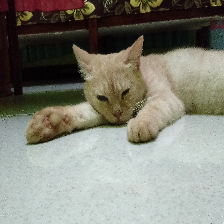

In [37]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[63].shape) 
array_to_img(train_imgs[63])

In [38]:
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 

print(train_labels[50:70], train_labels_enc[50:70])

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian', 'jovian'] [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [39]:
from tensorflow.keras.utils import to_categorical
train_labels_enc2 = to_categorical(train_labels_enc)
validation_labels_enc2 = to_categorical(validation_labels_enc)

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['jovian', 'jovian', 'jovian', 'jovian', 'jovian']


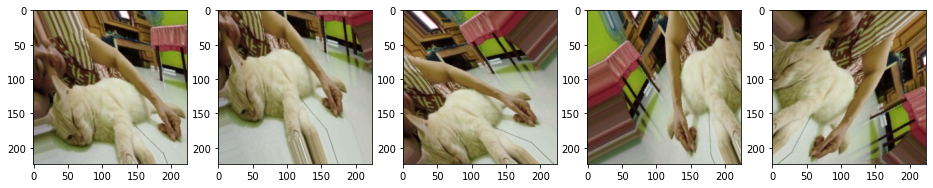

In [41]:
img_id = 100
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], 
 train_labels[img_id:img_id+1], 
 batch_size=1) 
cat = [next(cat_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat]) 
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [42]:
batch=10
train_generator = train_datagen.flow(train_imgs, train_labels_enc,batch_size=batch)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch,shuffle=False )

In [43]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [44]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = True

In [45]:
from keras.layers import Dense
from keras.models import Model
X= vggmodel.layers[-2].output
#X = Dense(256, activation ='relu')(X)
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)

In [46]:
from keras import optimizers
model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0), metrics=["accuracy"])
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
#checkpoint = ModelCheckpoint("vgg16_50.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
history=model_final.fit_generator(generator= train_generator, 
                            steps_per_epoch= (number_of_trainsamples/batch), 
                            epochs= 200, 
                            validation_data= val_generator, 
                            validation_steps=(number_of_testsamples/batch))
#hist=model_final.fit_generator(generator= train_generator, steps_per_epoch= (number_of_trainsamples/batch), epochs= 50, validation_data= val_generator, validation_steps=(number_of_testsamples/batch))
model_final.save_weights("/content/drive/My Drive/Upload/Machine Learning/Projects/Jovian Classifier/Saved Model/jovian_vgg16_lr1e-4_e200_m0.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
12/12 [==============================] - 5s 298ms/step - loss: 0.7503 - accuracy: 0.4747 - val_loss: 0.6939 - val_accuracy: 0.4750
Epoch 2/200
12/12 [==============================] - 3s 241ms/step - loss: 0.6760 - accuracy: 0.6209 - val_loss: 0.6825 - val_accuracy: 0.6000
Epoch 3/200
12/12 [==============================] - 3s 242ms/step - loss: 0.6692 - accuracy: 0.6002 - val_loss: 0.6731 - val_accuracy: 0.5500
Epoch 4/200
12/12 [==============================] - 3s 245ms/step - loss: 0.6492 - accuracy: 0.6723 - val_loss: 0.6649 - val_accuracy: 0.6000
Epoch 5/200
12/12 [==============================] - 3s 245ms/step - loss: 0.6499 - accuracy: 0.6606 - val_loss: 0.6508 - val_accuracy: 0.7500
Epoch 6/200
12/12 [==============================] - 3s 246ms/step - loss: 0.6543 - accuracy: 0.6411 - val_loss: 0.6406 - val_accuracy: 0.6500
Epoch 7/200
12/12 [==============================] - 3s 244ms/step - loss: 0.6302 - accuracy: 0.7800 - val_loss: 0.6313 - val_accuracy: 0.7750

In [48]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
# hist_csv_file = '/content/drive/My Drive/Upload/Akademik/Topsus/Dog vs Cat with VGG16/m0vgg16_200_lr1e-5.csv'
# with open(hist_csv_file, mode='w') as f:
    # hist_df.to_csv(f)

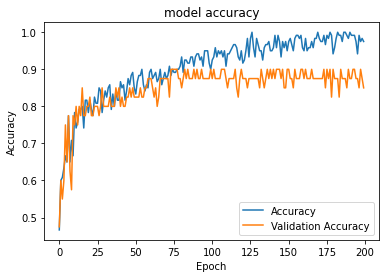

In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [50]:
val_generator.reset()
Y_pred = model_final.predict_generator(val_generator, number_of_testsamples/batch)
y_pred = np.where(Y_pred>0.5,1,0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [51]:
# print(validation_labels_enc)
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')

confmat=confusion_matrix(validation_labels_enc, y_pred)
print(confmat)

confusionmat_df = pd.DataFrame(confmat) 
confusionmat_csv_file = '/content/drive/My Drive/Upload/Akademik/Topsus/Dog vs Cat with VGG16/m0confusionmat_vgg16_200_lr1e-5.csv'
with open(confusionmat_csv_file, mode='w') as f:
    confusionmat_df.to_csv(f)

Confusion Matrix
[[18  2]
 [ 4 16]]


In [52]:
print('Classification Report')
target_name=['cat','dog']
print(classification_report(validation_labels_enc, y_pred, 
 target_names=target_name))

Classification Report
              precision    recall  f1-score   support

         cat       0.82      0.90      0.86        20
         dog       0.89      0.80      0.84        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



In [58]:
from tensorflow.keras.models import load_model

# model_file = open("/content/drive/My Drive/Upload/Machine Learning/Projects/Jovian Classifier/Saved Model/jovian_vgg16_lr1e-4_e200_m0.h5", 'r')
# model = load_model(model_final)

converter = tf.lite.TFLiteConverter.from_keras_model(model_final)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('/content/drive/My Drive/Upload/Machine Learning/Projects/Jovian Classifier/Saved Model/jovian_vgg16_lr1e-4_e200_m0.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp2qkyyl48/assets
model converted
